In [1]:
from smilesfeature import generate_smiles_feature
import pandas as pd

c:\ProgramData\Anaconda3\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


# Load data
- The dataset should inherently include a column named "SMILES," and it must contain a single target column for prediction. If the column name containing the SMILES format is different, please assign the name of that column to the "smiles_col" argument.

In [2]:
df = pd.read_csv("./data/big_smiles.csv")[:1000]

In [3]:
df.head()

,SMILES,pIC50,mol,num_atoms,logP
0,O=S(=O)(Nc1cccc(-c2cnc3ccccc3n2)c1)c1cccs1,4.26,<rdkit.Chem.rdchem.Mol object at 0x7f59df45bc30>,25,4.1591
1,O=c1cc(-c2nc(-c3ccc(-c4cn(CCP(=O)(O)O)nn4)cc3)...,4.34,<rdkit.Chem.rdchem.Mol object at 0x7f59a320c9e0>,36,3.6743
2,NC(=O)c1ccc2c(c1)nc(C1CCC(O)CC1)n2CCCO,4.53,<rdkit.Chem.rdchem.Mol object at 0x7f59a320cac0>,23,1.5361
3,NCCCn1c(C2CCNCC2)nc2cc(C(N)=O)ccc21,4.56,<rdkit.Chem.rdchem.Mol object at 0x7f59a320cba0>,22,0.9510
4,CNC(=S)Nc1cccc(-c2cnc3ccccc3n2)c1,4.59,<rdkit.Chem.rdchem.Mol object at 0x7f59a320c7b0>,21,3.2130


# Scatter plot
- Using the original DataFrame as input, we visualize the distribution of numeric columns as scatter plots.

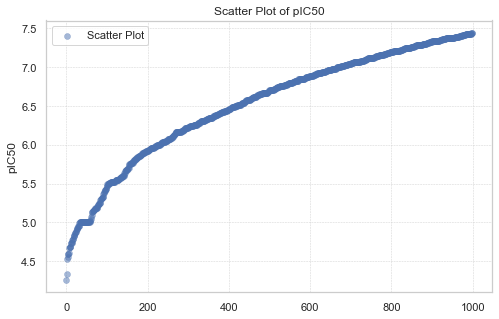

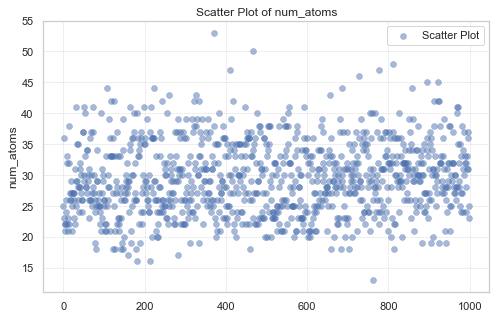

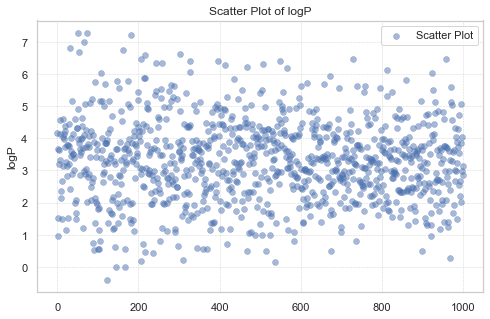

In [4]:
from smilesfeature import df_scatter_plot

df_scatter_plot(df)

# Feature generation
- Create fingerprint columns for SMILES representations based on various packages like RDKit, Mol2Vec, DataMol, MolFeat, sklearn, etc.
- Generate various derived variables to enable ML expansion.
- By default, it uses the 'simple' method, but if you provide the 'specific' argument, it creates various functions based on MACCS, FPVec, ECFP, and RDKit 2D descriptors, represented with suffixes like 'ecfp_'.
- You can vectorize the given SMILES string based on various derived variables, and they are created as columns with one-hot encoding for ML suitability.

In [5]:
df = df[:100]
print(len(df.columns))

5


In [6]:
df = generate_smiles_feature(df) # default method="simple"
print(len(df.columns))

299


In [7]:
df = generate_smiles_feature(df, method="specific")
print(len(df.columns))

[06:28:13] WARNING: not removing hydrogen atom without neighbors
[06:28:13] Initializing Normalizer
[06:28:13] Running Normalizer
[06:28:13] WARNING: not removing hydrogen atom without neighbors
[06:28:13] Initializing Normalizer
[06:28:13] Running Normalizer
[06:28:13] WARNING: not removing hydrogen atom without neighbors
[06:28:13] Initializing Normalizer
[06:28:13] Running Normalizer
[06:28:13] WARNING: not removing hydrogen atom without neighbors
[06:28:13] Initializing Normalizer
[06:28:13] Running Normalizer
[06:28:13] WARNING: not removing hydrogen atom without neighbors
[06:28:13] Initializing Normalizer
[06:28:13] Running Normalizer
[06:28:13] WARNING: not removing hydrogen atom without neighbors
[06:28:13] Initializing Normalizer
[06:28:13] Running Normalizer
[06:28:13] WARNING: not removing hydrogen atom without neighbors
[06:28:13] Initializing Normalizer
[06:28:13] Running Normalizer
[06:28:13] WARNING: not removing hydrogen atom without neighbors
[06:28:13] Initializing N

# Correlation heatmap
- Using derived variables generated based on the SMILES notation, we compare three correlation scores and visualize the top 10 highly correlated features.
- Similar to methodologies for calculating ELI5, SHAP values, or feature importance, this approach allows for a quick and straightforward assessment of multicollinearity and correlation from a data perspective.

In [ ]:
from smilesfeature import draw_corr

draw_corr(df, "pIC50")

# Train machine learning model
- The utility of this package lies in providing fingerprints of SMILES strings with various derived variables, assisting in insights into researchers' datasets. 
- Therefore, it primarily examines very simple LGBM models. This process serves as a way to check for limitations, given that many tasks are insufficient and have discrete outcomes and data. 
- It can also be used as a supplementary tool for reviewing dashboards later.

In [ ]:
from smilesfeature import train_lgbm

model, x_columns = train_lgbm(df, "pIC50")

In [ ]:
df['predicted_pIC50'] = model.predict(df[x_columns])

# Create Dashboard 
- Through the dashboard, you can determine which compounds exhibit what prediction performance. 
- Researchers with domain knowledge can assess the prediction performance for specific molecules, identifying both good and poor performers, which can guide further modeling research.

In [ ]:
from smilesfeature import create_inline_dash_dashboard

# Load your DataFrame and specify the columns
true_col = 'pIC50'
predicted_col = 'predicted_pIC50'

# Create and run the Dash dashboard
create_inline_dash_dashboard(df, true_col, predicted_col)


# Save reporting images

In [ ]:

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import rdMolDescriptors
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Function to calculate various metrics
def calculate_metrics(true_col, predicted_col):
    rmse = np.sqrt(mean_squared_error(true_col, predicted_col))
    mae = mean_absolute_error(true_col, predicted_col)
    r2 = r2_score(true_col, predicted_col)
    return rmse, mae, r2


def plot_and_save_subplots(df, folder, true_col, predicted_col, metrics, idx_start=1):
    os.makedirs(folder, exist_ok=True)
    for idx, (index, row) in enumerate(df.iterrows(), start=idx_start):
        fig, axs = plt.subplots(1, 2, figsize=(12, 6), dpi=300)

        # SMILES and molecular formula as title
        smiles = row.get('SMILES', 'Unknown')
        molecule = Chem.MolFromSmiles(smiles)
        formula = rdMolDescriptors.CalcMolFormula(molecule)
        axs[0].set_title(f"Molecule: {formula}\nSMILES: {smiles}")

        # Subplot for the image
        axs[0].imshow(row['image_array'])
        axs[0].axis('off')

        # Create and plot for each specified metric
        metric_values = {}
        for metric in metrics:
            true_value = np.array([row[true_col]])  # Ensure true_value is an array
            predicted_value = np.array([row[predicted_col]])  # Ensure predicted_value is an array

            if metric == 'RMSE':
                error = np.sqrt(mean_squared_error(true_value, predicted_value))
            elif metric == 'MAE':
                error = mean_absolute_error(true_value, predicted_value)
            elif metric == 'R2':
                error = r2_score(true_value, predicted_value)
            else:
                error = None

            metric_values[metric] = error

            axs[1].bar([f'True {metric}', f'Predicted {metric}'], [true_value[0], predicted_value[0]], color=['blue', 'red'])
            axs[1].text(0, true_value[0] * 1.05, f"True {metric}: {true_value[0]:.2f}", color='blue', fontsize=14)
            axs[1].text(1, predicted_value[0] * 1.05, f"Predicted {metric}: {predicted_value[0]:.2f}", color='red', fontsize=14)
            axs[1].text(0.5, max(true_value[0], predicted_value[0]) * 0.8, f"{metric} Error: {error:.2f}", color='black', fontsize=14)

        # Save the figure
        plt.show()
        plt.savefig(f"{folder}/{idx}.jpg", dpi=300)
        plt.clf()


# Example usage
metrics_list = ['RMSE']  # Pass the metric as a list even if it's just one metric RMSE, R2, MAE
true_column = 'pIC50'  # Replace with your true column name
predicted_column = 'predicted_pIC50'  # Replace with your predicted column name
plot_and_save_subplots(df[:1], 'output_folder', true_column, predicted_column, metrics_list)


In [ ]:
def plot_and_save_subplots(df, folder, true_col, predicted_col, metrics, idx_start=1):
    for idx, (index, row) in enumerate(df.iterrows(), start=idx_start):
        fig, axs = plt.subplots(1, 2, figsize=(12, 6), dpi=300)

        # SMILES and molecular formula as title
        smiles = row.get('SMILES', 'Unknown')
        molecule = Chem.MolFromSmiles(smiles)
        formula = rdMolDescriptors.CalcMolFormula(molecule)
        axs[0].set_title(f"Molecule: {formula}\nSMILES: {smiles}")

        # Subplot for the image
        axs[0].imshow(row['image_array'])
        axs[0].axis('off')

        # Create and plot for each specified metric
        metric_values = {}
        for metric in metrics:
            true_value = np.array([row[true_col]])  # Ensure true_value is an array
            predicted_value = np.array([row[predicted_col]])  # Ensure predicted_value is an array

            if metric == 'RMSE':
                error = np.sqrt(mean_squared_error(true_value, predicted_value))
            elif metric == 'MAE':
                error = mean_absolute_error(true_value, predicted_value)
            elif metric == 'R2':
                error = r2_score(true_value, predicted_value)
            else:
                error = None

            metric_values[metric] = error

            axs[1].bar([f'True {metric}', f'Predicted {metric}'], [true_value[0], predicted_value[0]], color=['blue', 'lightcoral'])
            axs[1].text(0, true_value[0] * 1.05, f"True {metric}: {true_value[0]:.2f}", color='blue', fontsize=14)
            axs[1].text(1, predicted_value[0] * 1.05, f"Predicted {metric}: {predicted_value[0]:.2f}", color='red', fontsize=14)
            axs[1].text(0.5, max(true_value[0], predicted_value[0]) * 0.8, f"Error: {error:.2f}", color='red', fontsize=14)

        # Access and display additional information (key-value pairs) from df['dm_descriptor_dict']
        additional_info = row['dm_descriptor_dict']
        for i, (key, value) in enumerate(additional_info.items()):
            info_text = f"{key}: {value:.2f}"
            axs[1].text(2.0, i * 0.2, info_text, fontsize=12, verticalalignment='bottom', horizontalalignment='left')

        # Save the figure
        plt.savefig(f"{folder}/{idx}.jpg", dpi=300)
        plt.clf()

# Example usage with the additional_info from df['dm_descriptor_dict']
metrics_list = ['RMSE']
true_column = 'pIC50'  # Replace with your true column name
predicted_column = 'predicted_pIC50'  # Replace with your predicted column name
plot_and_save_subplots(df, 'output_folder', true_column, predicted_column, metrics_list)
